# 95-869: Big Data and Large-Scale Computing Homework 5


## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset_challenge/dataset).

#### ** This assignment will cover: **
*  *Part 1 (30 Points):* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
*  *Part 2 (15 Points):* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/2.2.0/mllib-ensembles.html)
*  *Part 3 (20 Points):* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html)
*  *Part 4 (15 Points):* Topic modeling for text reviews [Link](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda)
*  *Part 5 (10 Points):* Word2Vec for text reviews [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec)
*  *Part 6 (10 Points):* Frequent pattern mining using FP-Growth algorithm [Link](https://spark.apache.org/docs/2.2.0/mllib-frequent-pattern-mining.html)
*  *Part 7 (Bonus: 20 Points):* Any additional and insightful exploratory data analysis or machine learning tasks you want to do.

#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Code of Conduct **

** Please follow the following guidelines with respect to collaboration: **

* By using the dataset, you agree to Yelp's terms of use available [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).
* You are free to use the Web, APIs, ML toolkits, etc. in this project to your best benefit. Please cite any online or offline sources (even casual sources like StackOverflow) if you use them in the project.
* The assignment is to be done individually. No collaboration is allowed between students. No discussion is allowed about the project with anyone else except the class instructors.

## Submission Instructions:


You will submit both an html and a Jupyter Notebook on Canvas. You will submit a PDF on Gradescope and assign the pages to their corresponding questions. No printout submission is expected. The submission issues below will result in points deduction:

1. If the student doesn't make the submission on both Canvas and Gradescope: -5% 
2. If the student submits an empty jupyter notebook/version obviously different from the submitted PDF: -5%
3. If the student does't assign pages to questions on Gradescope: -3%

Rename the notebook from "hw5_yelp_student.ipynb" to "studentid_hw5_yelp_student.ipynb" where "studentid" is your Andrew ID. Complete the assignment, execute all cells in the completed notebook, and make sure all results show up. Export the contents of the notebook by choosing "File > Download as > HTML" and saving the resulting file as "studentid_hw5_yelp_student.html" Convert the exported HTML file to PDF by using a feature such as the "Save as PDF" feature on Mac. Another way to get the PDF file is to do ctrl(or command) + P and save as a PDF. Submit the PDF solution to gradescope. Submit the IPython and exported html solution files on Canvas.

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory","25g").getOrCreate()
sc = spark.sparkContext
sc

23/04/26 22:17:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents,  numSlices=500)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question1: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
# TODO: Replace <FILL IN>

categories_rdd = businesses_rdd.flatMap(lambda b: b['categories'])
category_count_rdd = categories_rdd.map(lambda c: (c, 1)).reduceByKey(lambda x, y: x + y)
top_categories = category_count_rdd.sortBy(lambda x: x[1], False).take(5)
for category, count in top_categories:
    print(category, count)

Restaurants 21892
Shopping 8919
Food 7862
Beauty & Spas 4738
Nightlife 4340


** Question2: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>
# map each business dictionary to its city
cities_rdd = businesses_rdd.map(lambda b: b['city'])

# count the frequency of each city
city_count_rdd = cities_rdd.map(lambda c: (c, 1)).reduceByKey(lambda x, y: x + y)

# sort the cities by frequency in descending order
top_cities = city_count_rdd.sortBy(lambda x: x[1], False).take(5)

# print the top cities and their frequency
for city, count in top_cities:
    print(city, count)

Las Vegas 13601
Phoenix 8410
Charlotte 4224
Scottsdale 4039
Edinburgh 3031


** Question3: ** Plot the histogram of stars received by businesses.

Text(0, 0.5, 'Number of Businesses')

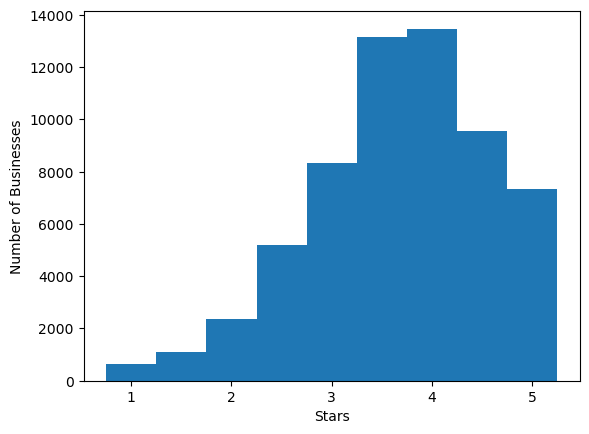

In [11]:
# TODO: Replace <FILL IN>

businesses_stars_counts = businesses_rdd.map(lambda b: b['stars']).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question4: ** Plot the histogram of number of reviews received by businesses.

Text(0, 0.5, 'Number of Businesses')

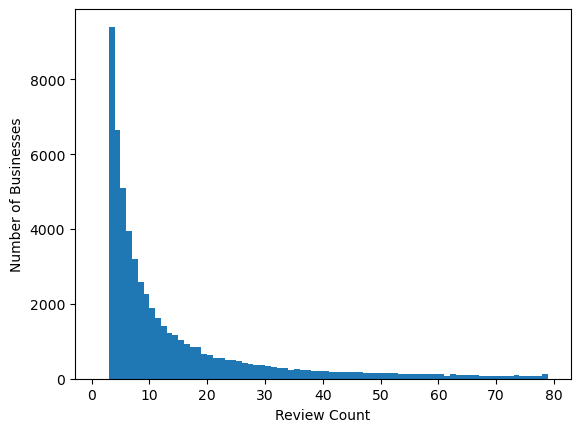

In [12]:
# TODO: Replace <FILL IN>

businesses_review_counts = businesses_rdd.map(lambda b : b['review_count']).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question5: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. Because the log-log plot shows a nearly linear relationship.

Text(0, 0.5, 'Number of Businesses')

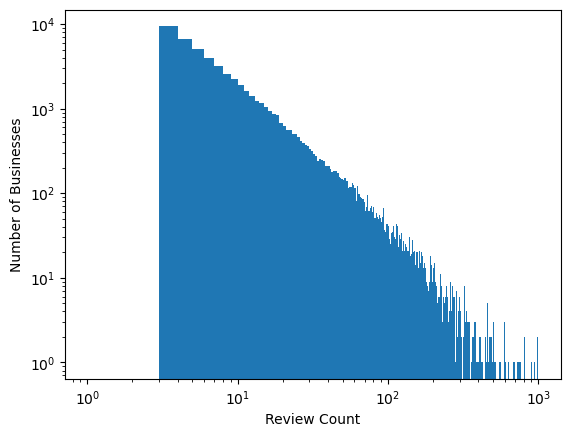

In [13]:
# TODO: Replace <FILL IN>

plt.hist(businesses_review_counts, bins=range(1,1000),log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question6: ** Plot the histogram of number of reviews written by users.

Text(0, 0.5, 'Number of Users')

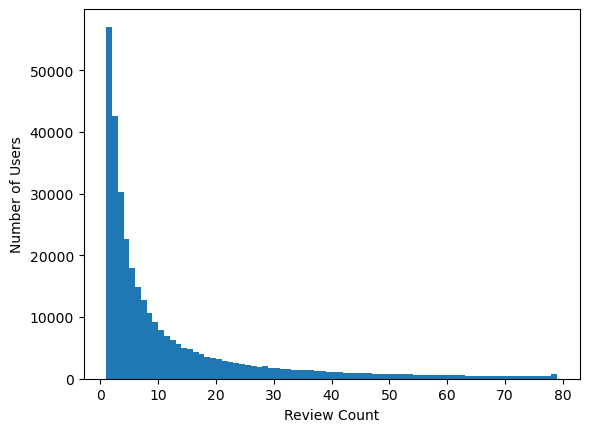

In [14]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda u: u['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question7: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, because linear relationship is shown by the log-log plot.

Text(0, 0.5, 'Number of Businesses')

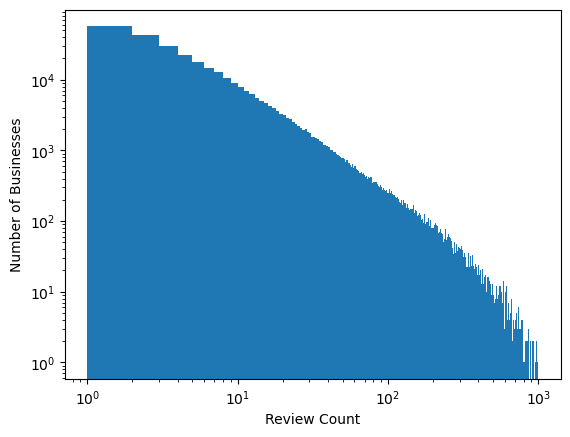

In [15]:
# TODO: Replace <FILL IN>

plt.hist(users_review_counts, bins=range(1,1000), log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question8: ** Plot the histogram of number of friends a Yelp user has.

Text(0, 0.5, 'Number of Users')

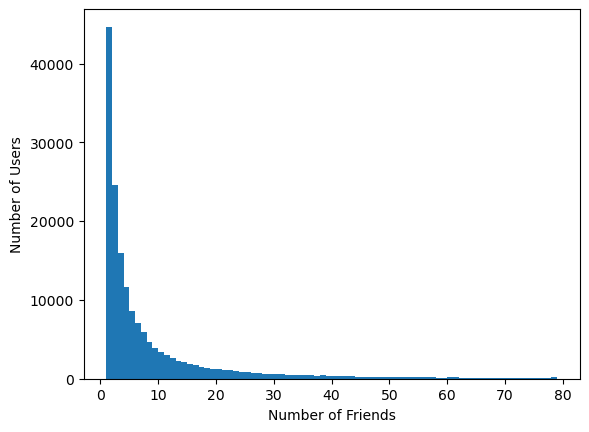

In [16]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda u: len(u['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question9: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, the linear relaitionship in log-log plot indicates the Power-Law relationship in orginal dataset.

Text(0, 0.5, 'Number of Users')

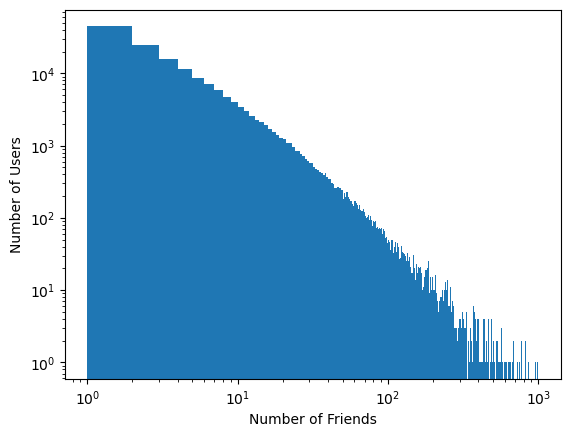

In [17]:
# TODO: Replace <FILL IN>

plt.hist(user_friend_counts, bins=range(1,1000), log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question10: ** Plot the histogram of number of fans a Yelp user has.

Text(0, 0.5, 'Number of Users')

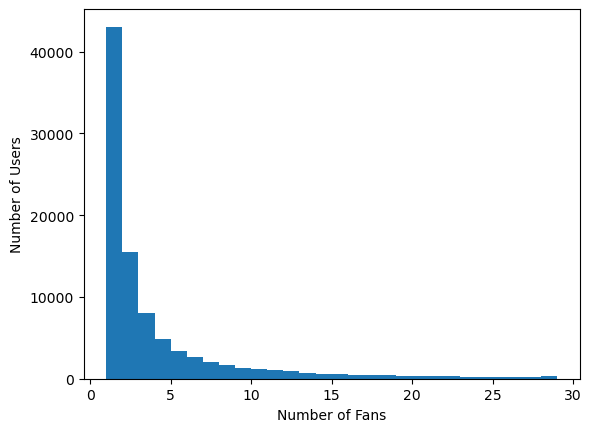

In [18]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda u: u['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question11: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes,becasue of the linear relation shown in the log-log plot

Text(0, 0.5, 'Number of Users')

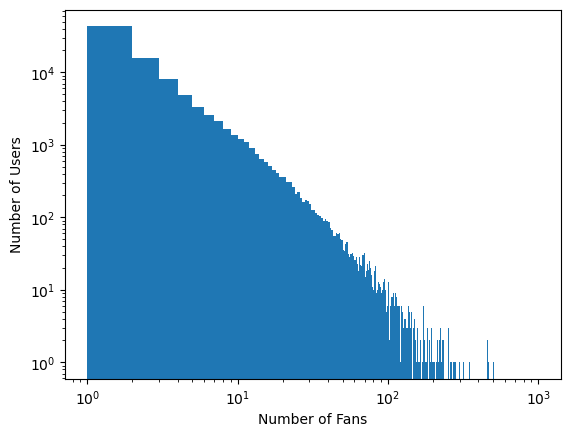

In [19]:
# TODO: Replace <FILL IN>

plt.hist(users_fan_counts, bins=range(1,1000), log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question12: ** Plot the histogram of number of checkins per Yelp business.

Text(0, 0.5, 'Number of Businesses')

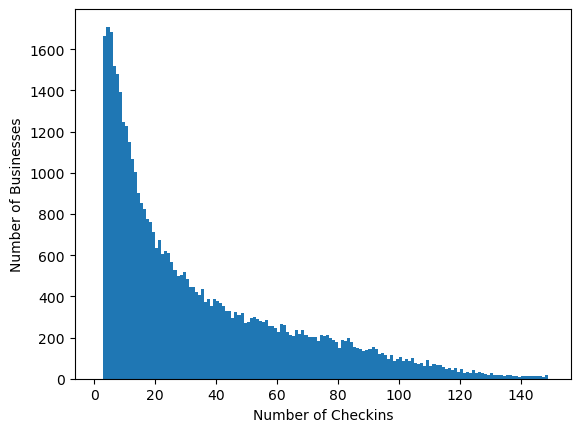

In [20]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda c:len(c['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question13: ** Plot the above histogram but now on a log-log scale using `bins=range(3,200)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: **  It is not a Power Law because the log-log scale plot is not showing linear relationship.

Text(0, 0.5, 'Number of Businesses')

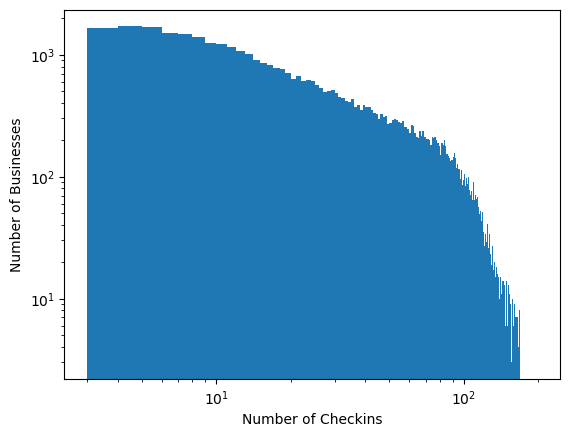

In [21]:
# TODO: Replace <FILL IN>

plt.hist(business_checkin_counts, bins=range(3,200), log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question14: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [22]:
# TODO: Replace <FILL IN>

max_checkin_count = max(checkins_rdd.map(lambda c:len(c['checkin_info'])).collect())
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda c: len(c['checkin_info']) == max_checkin_count) \
    .map(lambda x: x['business_id']).collect()
len(business_ids_with_max_checkins)

41

In [23]:
# TODO: Replace <FILL IN>

business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x: x['business_id'] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question15: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** Since most of the businesses are in LA, I feel like it might because LA has a large number of tourists and the economy in LA is also prosperous.

** Question16: ** Plot a histogram of the stars associated with business reviews.

Text(0, 0.5, 'Number of Reviews')

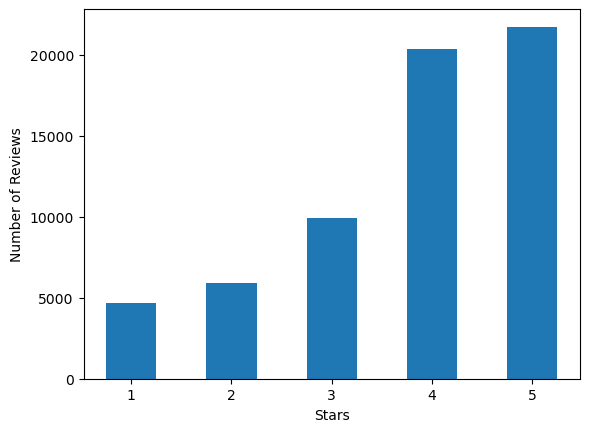

In [24]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda x: x['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question17: ** Plot a histogram of the number of reviews written per Yelp user.

Text(0, 0.5, 'Number of Users')

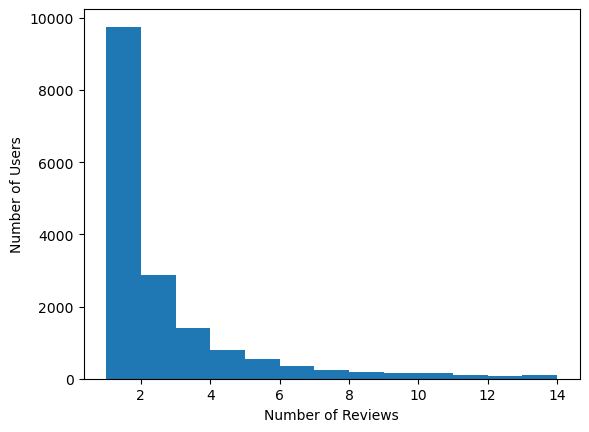

In [25]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda x: x['user_id']).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question18: ** Plot a histogram of the number of reviews written per Yelp business.

Text(0, 0.5, 'Number of Businesses')

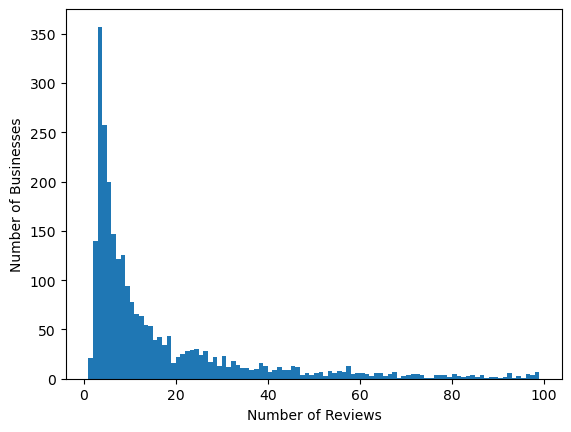

In [26]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda x: x['business_id']).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question19: ** Plot a histogram of the number of useful votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

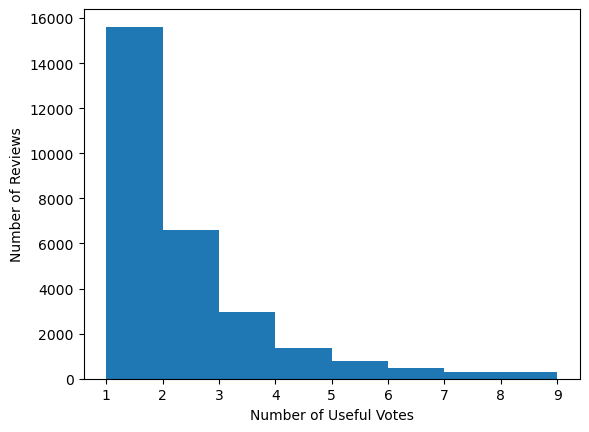

In [27]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda x:x['votes']['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question20: ** Plot a histogram of the number of funny votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

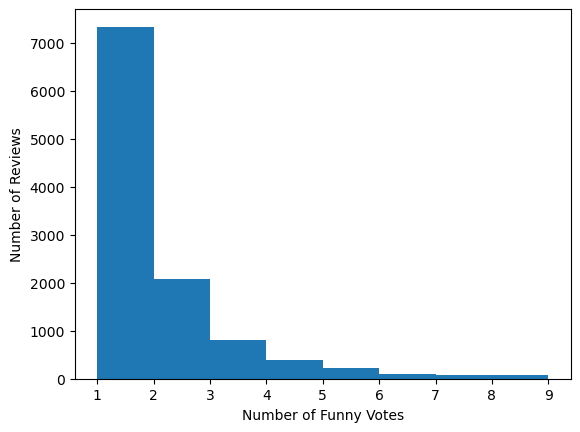

In [28]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda x:x['votes']['funny']).collect()
plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question21: ** Plot a histogram of the number of cool votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

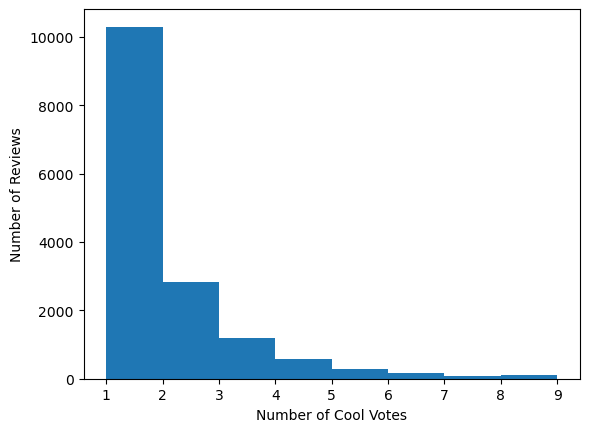

In [29]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda x:x['votes']['cool']).collect()
plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question22: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

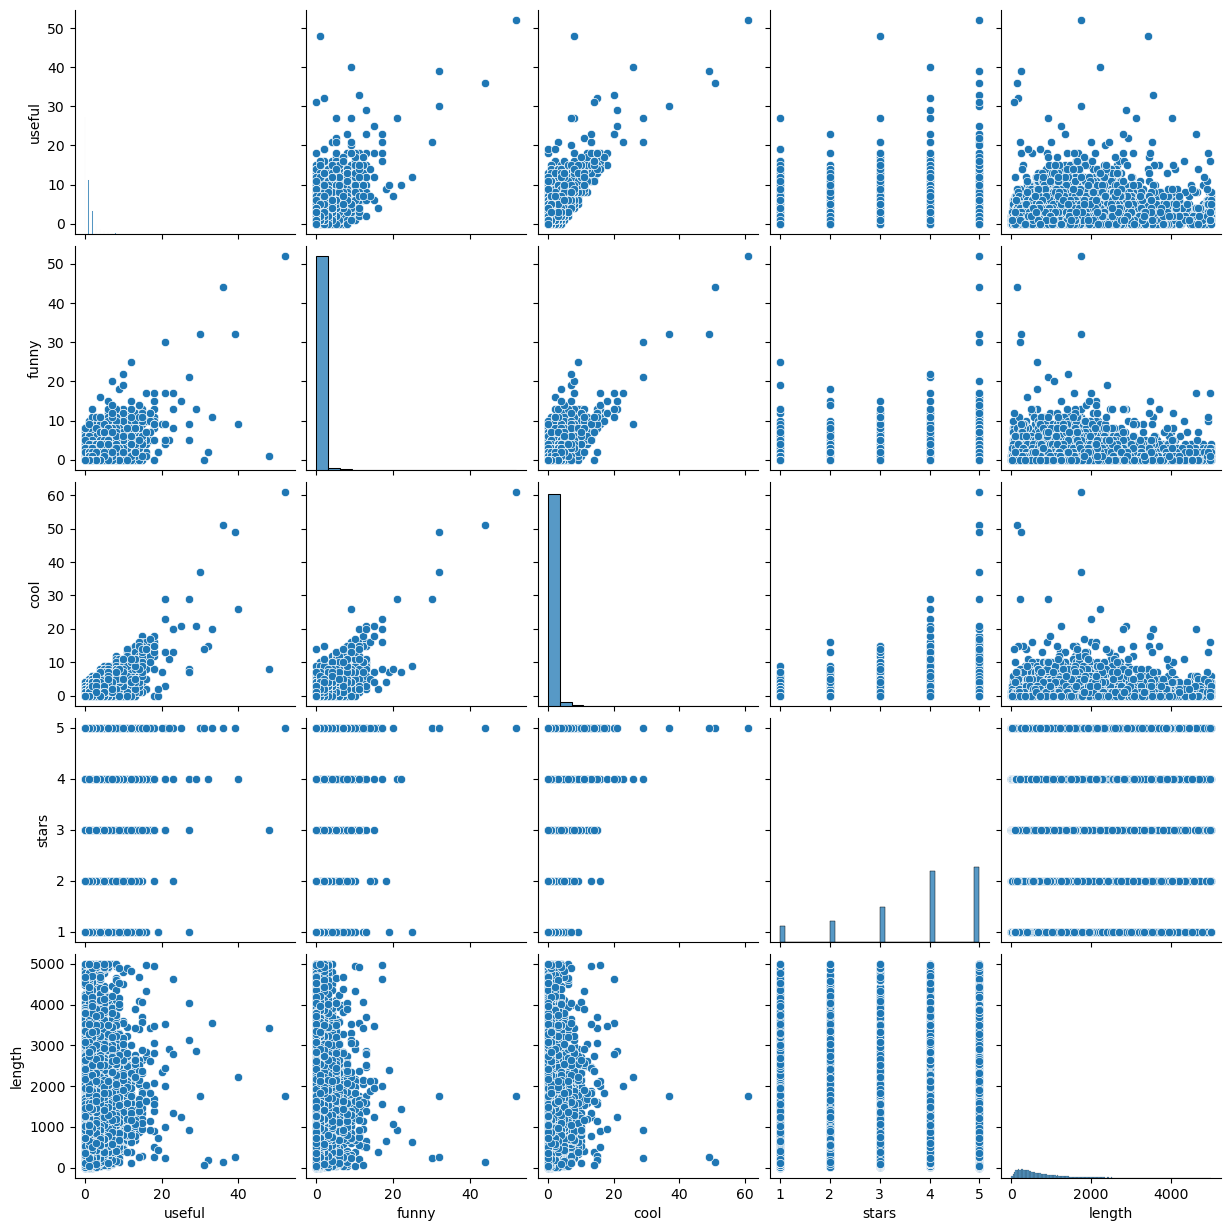

In [30]:
# TODO: Replace <FILL IN>

review_votes_length = reviews_rdd.map(lambda x: (x['votes']['useful'], x['votes']['funny'], x['votes']['cool'], x['stars'], len(x['text']))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question23: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [31]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda x: x['name'] in male_names)
female_users = users_rdd.filter(lambda x: x['name'] in female_names)

male_user_ids = male_users.map(lambda x: x['user_id']).collect()
female_user_ids = female_users.map(lambda x: x['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question24: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [32]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda x: x['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x: x['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x: len(x))
female_word_count = female_reviews.map(lambda x: len(x))

print ('Male and female review length averages: ', male_word_count.mean(),female_word_count.mean())

Male and female review length averages:  697.3215248363497 760.4281720764092


** Question25: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** Yes, famale reviewers tend to write longer reviews because when it comes to reviews with longer length, number of reviews from females are generally larger than those from males. The major trend is the numbers of reviews increases first then decreases with the increase of length, so people tend to write medium-length reviews.

In [33]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

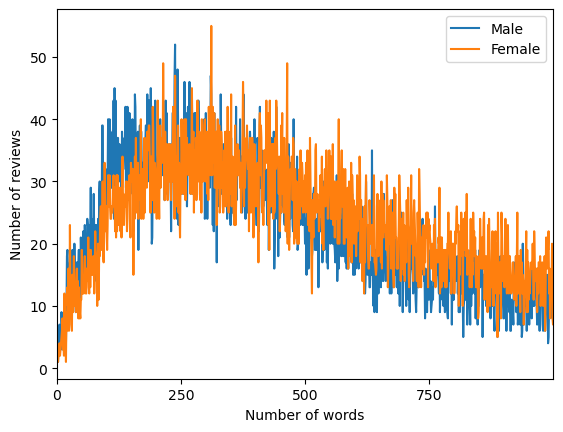

In [34]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [35]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question1: ** Fill in the necessary code to calculate word counts from text reviews below.

In [36]:
# TODO: Replace <FILL IN>

max_words = 50000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x: x[0].split(" ")).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  50000


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [37]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i: unique_words[i] for i in range(len(unique_words))}

** Question3: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [38]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0],SparseVector(num_unique_words,sorted(set(x[1])),[x[1].count(i) for i in sorted(set(x[1]))])))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (50000,[0,1,2,4,7,9,10,12,13,16,17,20,21,26,39,43,49,56,86,105,113,125,163,167,193,204,232,282,293,302,339,347,358,359,465,485,658,659,673,752,765,930,982,995,1086,1118,1437,1887,2245,2375,2925,3646,3892,4104,4282,4631,4725,4726,4889,5276,5634,5912,6052,6383,7508,10225,14660,15114,15542,16604,16605,17198,26514,30902,33876,37766],[8.0,3.0,1.0,5.0,5.0,1.0,1.0,1.0,2.0,4.0,6.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (50000,[0,4,6,9,10,18,20,36,37,42,45,55,76,80,88,100,110,131,200,239,298,313,323,358,373,387,399,442,465,602,639,716,903,926,976,2925,3470,6464,6595,10371,15543,17810,22105],[2.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.

** Question4: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [39]:
# TODO: Replace <FILL IN>

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8,0.2],seed=123)

** Question5: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [40]:
# TODO: Replace <FILL IN>
funny_votes = doc_vectors.map(lambda lp: lp.label)
most_common_value = funny_votes.countByValue().items()
most_common_value = sorted(most_common_value, key=lambda x: x[1], reverse=True)[0][0]

most_common_prediction = most_common_value
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 0.9409398133247505
Learned baseline prediction:  0.0


** Question6: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [41]:
# TODO: Replace <FILL IN>

dt_model = DecisionTree.trainRegressor(doc_vectors_train,impurity='variance',maxDepth=5,categoricalFeaturesInfo={})

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

23/04/26 22:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1153.9 KiB
23/04/26 22:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1913.2 KiB
23/04/26 22:18:58 WARN DAGScheduler: Broadcasting large task binary with size 1914.0 KiB
23/04/26 22:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1914.7 KiB
23/04/26 22:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1915.7 KiB
23/04/26 22:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1916.5 KiB
23/04/26 22:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1290.1 KiB


Validation Root Mean Squared Error (Decision Tree) = 0.9319502106705257
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 27 nodes
  If (feature 23839 <= 0.5)
   If (feature 2 <= 6.5)
    If (feature 10225 <= 1.5)
     If (feature 17444 <= 1.5)
      If (feature 2170 <= 1.5)
       Predict: 0.2406362114326716
      Else (feature 2170 > 1.5)
       Predict: 6.111111111111111
     Else (feature 17444 > 1.5)
      Predict: 18.0
    Else (feature 10225 > 1.5)
     Predict: 20.0
   Else (feature 2 > 6.5)
    If (feature 1852 <= 3.0)
     If (feature 43342 <= 0.5)
      If (feature 4195 <= 1.5)
       Predict: 0.642232602706911
      Else (feature 4195 > 1.5)
       Predict: 19.0
     Else (feature 43342 > 0.5)
      If (feature 1 <= 29.5)
       Predict: 12.0
      Else (feature 1 > 29.5)
       Predict: 17.0
    Else (feature 1852 > 3.0)
     Predict: 32.0
  Else (feature 23839 > 0.5)
   If (feature 30 <= 0.5)
    If (feature 0 <= 2.5)
     Predict: 32.0
    Else (

** Question7: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [42]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train, impurity='variance', numTrees=10, categoricalFeaturesInfo={}, maxDepth=5)

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

23/04/26 22:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1153.9 KiB
23/04/26 22:19:37 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/04/26 22:19:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/04/26 22:19:55 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/04/26 22:20:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/04/26 22:20:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/04/26 22:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1316.5 KiB
23/04/26 22:20:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/26 22:20:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Validation Root Mean Squared Error (Random Forest) = 0.8298416334459857
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 4 <= 4.5)
     If (feature 42284 <= 0.5)
      If (feature 27858 <= 0.5)
       If (feature 46476 <= 0.5)
        If (feature 0 <= 6.5)
         Predict: 0.19494800339313204
        Else (feature 0 > 6.5)
         Predict: 0.40269009058468297
       Else (feature 46476 > 0.5)
        Predict: 12.0
      Else (feature 27858 > 0.5)
       If (feature 2 <= 1.5)
        Predict: 13.0
       Else (feature 2 > 1.5)
        Predict: 0.0
     Else (feature 42284 > 0.5)
      Predict: 15.0
    Else (feature 4 > 4.5)
     If (feature 1023 <= 2.5)
      If (feature 415 <= 3.0)
       If (feature 19358 <= 1.0)
        If (feature 18234 <= 0.5)
         Predict: 0.6028659160696008
        Else (feature 18234 > 0.5)
         Predict: 17.0
       Else (feature 19358 > 1.0)
        Predict: 15.0
      Else (feature 415 > 3.0)
       P

** Question8: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** The maximum number of iterations in GBT is equal to the number of trees in the ensemble. Therefore, setting the maximum number of iterations to 10 will create an ensemble of 10 trees.

In GBT, the maximum depth of trees is an important hyperparameter that can affect the performance of the model. However, it is not necessary to set the maximum depth of trees in the ensemble because GBT builds the trees iteratively, adding new trees that focus on the residuals or errors made by the previous trees. In other words, the algorithm automatically adjusts the depth of each new tree to optimize the overall model performance.

Therefore, while it is not necessary to set the maximum depth of trees in the ensemble, it is important to keep track of the performance of the model on the validation set as the number of trees in the ensemble increases. If the model starts to overfit, one strategy could be to decrease the maximum depth of each tree or increase the regularization parameters to reduce the complexity of the model.

In [44]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, numIterations=10)

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

23/04/26 22:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1154.1 KiB
23/04/26 22:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1914.5 KiB
23/04/26 22:22:44 WARN DAGScheduler: Broadcasting large task binary with size 1915.4 KiB
23/04/26 22:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1916.0 KiB
23/04/26 22:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1922.6 KiB
23/04/26 22:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1923.2 KiB
23/04/26 22:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1923.8 KiB
23/04/26 22:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1925.8 KiB
23/04/26 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1926.4 KiB
23/04/26 22:23:05 WARN DAGScheduler: Broadcasting large task binary with size 1927.0 KiB
23/04/26 22:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1928.9 KiB
23/04/26 22:23:11 WAR

Validation Root Mean Squared Error (Gradient Boosting Trees) = 0.8988002061484294
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 23839 <= 0.5)
     If (feature 2 <= 6.5)
      If (feature 10225 <= 1.5)
       Predict: 0.24232424677187947
      Else (feature 10225 > 1.5)
       Predict: 20.0
     Else (feature 2 > 6.5)
      If (feature 1852 <= 3.0)
       Predict: 0.6477490421455939
      Else (feature 1852 > 3.0)
       Predict: 32.0
    Else (feature 23839 > 0.5)
     If (feature 30 <= 0.5)
      If (feature 0 <= 2.5)
       Predict: 32.0
      Else (feature 0 > 2.5)
       Predict: 52.0
     Else (feature 30 > 0.5)
      If (feature 0 <= 24.5)
       Predict: 0.6666666666666666
      Else (feature 0 > 24.5)
       Predict: 6.0
  Tree 1:
    If (feature 171 <= 0.5)
     If (feature 1023 <= 2.5)
      If (feature 17444 <= 1.5)
       Predict: -0.057005541546383036
      Else (feature 17444 > 1.5)
       Predict: 35.51535150645623
   

** Question9: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** The random forest ensemble has the best validaation RMSE results.

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [46]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question1: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [48]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda x:x['user_id']).collect()
review_business_ids = reviews_rdd.map(lambda x:x['business_id']).collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

** Question2: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [49]:
# TODO: Replace <FILL IN>

ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']], business_to_index_dict[x['business_id']], float(x['stars'])))
print(ratings_rdd.take(2))

[Rating(user=0, product=2, rating=5.0), Rating(user=59244, product=2, rating=2.0)]


** Question3: ** Let us randomly split data into 80% train and 20% validation set.

In [50]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8,0.2],seed=123)

** Question4: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [53]:
# TODO: Replace <FILL IN>

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train,rank,numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

23/04/26 22:28:56 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/26 22:28:56 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/04/26 22:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:29:16 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=1) = Train 1.6004780937136214, Validation 7.9489499580395275


23/04/26 22:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=2) = Train 1.9173291465089397, Validation 5.998405821596218


23/04/26 22:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:30:08 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=3) = Train 0.6208845923500654, Validation 2.391890468590271


23/04/26 22:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=4) = Train 0.5342779072494988, Validation 2.3263872786352473


23/04/26 22:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=5) = Train 0.49125354326817616, Validation 2.357856705476426


23/04/26 22:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=6) = Train 0.4486035200201335, Validation 2.3203129854963382


23/04/26 22:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=7) = Train 0.40429760528585, Validation 2.17713515632172


23/04/26 22:32:11 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=8) = Train 0.37285443128206136, Validation 2.1359648595190164


23/04/26 22:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=9) = Train 0.3423861360329778, Validation 2.1258380705404436


23/04/26 22:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=10) = Train 0.32840293223942857, Validation 2.221428336110395


23/04/26 22:33:26 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=11) = Train 0.3052924359512439, Validation 2.172168721105334


23/04/26 22:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:33:57 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=12) = Train 0.2931832687142771, Validation 2.188840943821579


23/04/26 22:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=13) = Train 0.27486801439205893, Validation 2.0700889660922464


23/04/26 22:34:44 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=14) = Train 0.2630965415669356, Validation 2.068676252206849


23/04/26 22:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=15) = Train 0.2541961847286378, Validation 2.1479002121159576


23/04/26 22:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:35:40 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=16) = Train 0.24217309920247543, Validation 2.051023469612301


23/04/26 22:36:03 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=17) = Train 0.23593637168979287, Validation 2.0044845579756263


23/04/26 22:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=18) = Train 0.2272161000381025, Validation 2.0419972523659675


23/04/26 22:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:36:57 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=19) = Train 0.21995540041083958, Validation 1.9634323333709685


23/04/26 22:37:21 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:37:24 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=20) = Train 0.21512536425724046, Validation 2.0285622115496107


23/04/26 22:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:37:50 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=40) = Train 0.1879496612439177, Validation 1.7674615226277601


23/04/26 22:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:38:17 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=60) = Train 0.18625694251199285, Validation 1.683138794984039


23/04/26 22:38:39 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=80) = Train 0.1858388073632664, Validation 1.6355932102448112


23/04/26 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=100) = Train 0.18559776843537965, Validation 1.6077720264967865


23/04/26 22:39:32 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
23/04/26 22:39:36 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB


Root Mean Squared Error (rank=120) = Train 0.18556286932849614, Validation 1.6087540518552463


23/04/26 22:39:58 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB
23/04/26 22:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB


Root Mean Squared Error (rank=140) = Train 0.18550785087891225, Validation 1.6037652239044715


23/04/26 22:40:24 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB
23/04/26 22:40:27 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB


Root Mean Squared Error (rank=160) = Train 0.1854636940923264, Validation 1.590863794082157


23/04/26 22:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB
23/04/26 22:40:55 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB


Root Mean Squared Error (rank=180) = Train 0.18542492327794097, Validation 1.6025670201787745


23/04/26 22:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB
23/04/26 22:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB


Root Mean Squared Error (rank=200) = Train 0.185475013603787, Validation 1.5871643312131047


** Question5: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** I would choose rank = 25 the RMSE reaches the smallest for both training dataset and validation dataset at rank = 25, and remains stable afterwards.

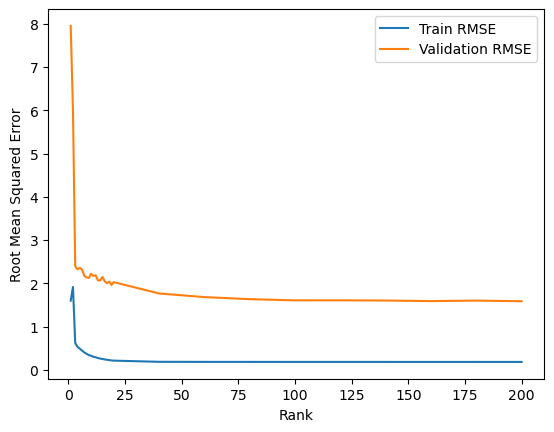

In [54]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [45]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question1: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [56]:
# TODO: Replace <FILL IN>

# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x:x['text'])
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x: -x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  192742


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [57]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [59]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x: SparseVector(num_unique_words,sorted(set(x)),[x.count(i) for i in sorted(set(x))]))
# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x:[x[1],x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(192742, {8: 2.0, 114: 1.0, 311: 1.0, 1209: 1.0, 1315: 1.0, 1444: 1.0, 1805: 1.0, 1987: 1.0, 2249: 1.0, 2738: 1.0, 2965: 1.0, 3148: 1.0, 3166: 1.0, 3530: 1.0, 3614: 1.0, 3977: 1.0, 4305: 1.0, 4391: 1.0, 4700: 1.0, 6041: 1.0, 8947: 1.0, 11064: 1.0, 13456: 1.0, 14371: 1.0, 23207: 1.0, 54812: 1.0, 77509: 1.0, 77510: 1.0, 77511: 1.0, 77512: 1.0})], [1, SparseVector(192742, {1805: 1.0, 2231: 1.0, 4799: 1.0, 5281: 1.0, 8776: 1.0, 12656: 1.0, 15459: 1.0, 17524: 1.0})]]


** Question4: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [60]:
# TODO: Replace <FILL IN>

lda_model =  LDA.train(doc_vectors,k=100,seed=42)

** Question5: ** Display the LDA model vocabulary size.

In [61]:
# TODO: Replace <FILL IN>

print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  192742


** Question6: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

In [62]:
# TODO: Replace <FILL IN>

topics=lda_model.topicsMatrix()
for i in range(5):
    index=lda_model.describeTopics(100)[i][0]
    print(i)
    print([index_to_word_dict[x] for x in index])

0
['noodle', 'bean', 'sign', 'choices', 'paying', 'general', 'finished', 'pancakes', 'pepper', 'up,', 'charge', 'great!', "you'd", 'tasty,', 'chili', 'best.', 'recommended', 'covered', 'thick', 'apple', 'somewhere', 'bottom', 'inside.', 'please', 'times.', 'thinking', 'hand', 'wall', 'minutes.', "they've", 'is,', 'generally', 'orders', 'share', 'sour', 'area,', 'except', 'true', 'special.', 'oil', 'thank', 'limited', 'greasy', 'picked', 'visit.', 'forget', 'dressing', 'clearly', 'side,', 'burrito', 'seriously', 'and,', 'employees', 'card', 'penn', 'location.', 'personal', 'hostess', 'atmosphere,', 'minute', 'amazing!', 'creamy', 'perfect.', 'pricey', 'selection.', 'pizza,', 'meal,', 'corner', 'room.', 'thin', 'fresh.', 'means', 'okay,', 'avoid', 'mine', 'cook', 'us,', 'town.', 'you,', '(not', 'small,', 'whatever', 'total', 'bread.', 'normally', 'life', 'longer', 'girlfriend', 'bars', "we're", 'terrible', 'wait.', 'recent', 'smaller', 'willing', 'delivery', 'weeks', 'nicely', 'nearly', 

1
['up,', 'thank', 'charge', 'great!', 'pizza,', 'times.', 'finished', 'seriously', 'sour', 'somewhere', 'wall', 'please', 'choices', 'share', 'sign', 'tasty,', 'generally', 'except', 'noodle', 'best.', 'thick', 'limited', 'mine', 'employees', 'visit.', 'true', "they've", "you'd", 'total', 'apple', 'personal', 'atmosphere,', 'selection.', 'meal,', 'dressing', 'pepper', 'side,', 'general', 'room.', 'foods', 'forget', 'recommended', 'hand', 'mussels', 'bottom', 'pancakes', 'life', 'covered', 'town.', 'paying', 'burger.', 'thinking', 'bread.', 'pricey', 'inside.', '(not', 'chili', 'whatever', 'picked', 'terrible', 'minute', 'means', 'greasy', 'recent', '...', 'creamy', 'bean', 'bars', 'honestly', 'fresh.', 'orders', 'else.', 'oil', 'amazing!', 'avoid', 'small,', 'museum', 'special.', 'delivery', 'clearly', 'stayed', 'veggies', 'bunch', 'is,', 'banana', 'oh,', 'original', 'location.', 'supposed', 'minutes.', 'nearly', 'dogs', 'normally', 'rooms', 'back!', 'okay,', 'rude', 'thin', 'longer',

2
['thank', 'thick', 'bottom', 'sour', 'noodle', 'forget', 'best.', 'great!', 'bean', 'finished', 'up,', 'choices', 'burrito', 'limited', 'chili', 'wall', 'true', 'except', 'pepper', 'paying', 'generally', 'atmosphere,', 'times.', 'oil', 'side,', 'covered', ',', 'charge', 'recommended', 'pancakes', 'is,', 'sign', 'terrible', 'general', 'tasty,', 'clearly', 'somewhere', 'please', 'share', 'minute', 'apple', 'inside.', "you'd", 'room.', 'orders', 'perfect.', 'recent', 'selection.', 'hand', 'location.', 'and,', 'dressing', 'delivery', 'honestly', 'special.', 'thinking', 'greasy', 'thin', 'bread.', 'byob', "we're", 'picked', 'means', 'wait.', 'cook', 'card', "they've", 'meal,', 'mine', 'you,', 'bars', 'amazing!', 'creamy', 'visit.', 'goat', 'pizza,', 'greeted', 'overly', 'employees', '...', 'personal', 'nearly', 'salty', 'burger.', 'stayed', 'corner', 'else.', 'prices.', 'original', 'pricey', 'back!', 'seriously', 'longer', 'veggies', 'weeks', 'okay,', 'hostess', 'total', 'dishes.', 'life'

3
['side,', 'atmosphere,', 'general', 'please', 'is,', 'somewhere', 'paying', 'best.', 'tasty,', 'limited', 'thank', 'pepper', 'charge', 'except', 'pancakes', "they've", 'room.', 'apple', 'mine', 'wall', 'times.', 'clearly', "you'd", 'area,', 'up,', 'special.', 'choices', 'bars', 'inside.', 'sour', 'life', 'thinking', 'sign', 'recommended', 'forget', 'selection.', 'true', 'perfect.', 'orders', 'and,', 'la', 'avoid', 'wait.', 'else.', 'thick', 'great!', 'bottom', 'generally', 'corner', 'bread.', 'supposed', 'employees', 'pricey', 'okay,', 'share', 'recent', 'dressing', 'visit.', 'finished', 'terrible', 'creamy', 'penn', 'nearly', 'thin', 'us,', 'minute', 'pizza,', 'hand', 'small,', 'means', 'seriously', 'location.', 'longer', 'covered', 'chili', 'kinda', 'greeted', ',', 'greasy', 'rooms', 'times,', 'noodle', 'delivery', 'bean', 'cook', 'hostess', 'toast', 'personal', 'burger.', "we're", 'honestly', 'foods', 'dogs', 'total', 'burrito', 'stayed', 'oil', 'minutes.', 'town.', 'card']


4
['up,', 'charge', 'great!', 'best.', 'limited', 'choices', 'noodle', 'finished', 'pepper', 'thick', 'general', 'bottom', 'tasty,', 'side,', 'sign', 'somewhere', 'times.', 'except', 'wall', 'thank', 'forget', 'atmosphere,', 'burrito', 'paying', 'apple', 'dressing', 'recommended', 'and,', 'covered', 'please', "you'd", "they've", 'share', 'bean', 'pizza,', 'hand', 'thinking', 'true', 'special.', 'generally', 'meal,', 'employees', 'pancakes', 'room.', 'small,', 'area,', 'north', 'cook', 'thin', 'personal', 'mine', 'minute', 'oil', 'sour', 'pricey', 'life', 'seriously', 'location.', 'burger.', 'avoid', 'chili', 'honestly', "we're", 'picked', 'greasy', 'fresh.', 'clearly', 'supposed', 'means', 'creamy', 'is,', 'card', 'you,', 'smaller', 'town.', 'kinda', 'inside.', 'perfect.', 'visit.', 'museum', 'grill', 'them,', 'terrible', 'wait.', '8', 'options.', 'orders', 'amazing!', 'minutes.', 'selection.', 'greeted', '...', 'credit', 'pumpkin', 'center', 'longer', 'corner', 'drink.', 'dishes.', 'b

# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [63]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [64]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question1: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [65]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).fit(review_docs)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [66]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['krispy', 'seasoning', 'fat', 'tobiko', 'noodles']
Words most similar to  pepper  :  ['mayo', 'broccoli', 'wasabi', 'buttered', 'garlic']
Words most similar to  restaurant  :  ['location', 'yiv', 'establishment', 'pusadees', 'folinos']
Words most similar to  italian  :  ['style', 'american', 'ubiquitous', 'turkish', 'pizza']
Words most similar to  indian  :  ['cuisine', 'chinese', 'vietnamese', 'asian', 'joints']
Words most similar to  chinese  :  ['indian', 'mexican', 'asian', 'cuisine', 'filipino']
Words most similar to  direction  :  ['insert', 'web', 'beaver', 'bathing', 'edgewood']
Words most similar to  pittsburgh  :  ['pgh', 'shadyside', 'town', 'nyc', 'los']
Words most similar to  burgh  :  ['city', 'strip', 'willys', 'planet', 'district']
Words most similar to  city  :  ['burgh', 'willys', 'planet', 'district', 'parks']
Words most similar to  location  :  ['neighborhood', 'scene', 'restaurant', 'oneoff', 'primo']
Words most similar to  cmu  :  

** Question2: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: **  There are several synonyms, e.g., salt and seasoning, pittsburgh and pgh and shadyside. Words like movie and matrix are spurious and not good substitutes for cmu.

# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [67]:
from pyspark.mllib.fpm import FPGrowth

** Question1: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [69]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda x: x['categories'])

fpgrowth_model = FPGrowth.train(business_categories, 0.01, 10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/04/26 23:03:15 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question2: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [70]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories,0.001,10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/04/26 23:06:00 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question3: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** No.

# ** Part 7: Bonus Analysis (if any) **

Here, you can include any additional and insightful exploratory data analysis or machine learning tasks you have carried out in addition to the guided exploration of the dataset above. Feel free to add code/markdown cells here to present your analysis.